In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import re


In [31]:
def parse_bridge(filename, n=5):
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Find Fermi level
    fermi_level = None
    for line in lines:
        if "Fermi level:" in line:
            fermi_level = float(line.split(":")[1].strip())
            break

    if fermi_level is None:
        raise ValueError("Fermi level not found.")

    # Find band energies and occupancies
    band_start = None
    for i, line in enumerate(lines):
        if re.match(r"\s*Band\s+Eigenvalues\s+Occupancy", line):
            band_start = i + 1
            break

    if band_start is None:
        raise ValueError("Band energies section not found.")

    energies = []
    occupancies = []
    for line in lines[band_start:]:
        if not line.strip() or not re.match(r"\s*\d+", line):
            break
        parts = line.split()
        energy = float(parts[1])
        occ = float(parts[2])
        energies.append(energy)
        occupancies.append(occ)

    # Find index closest to Fermi level
    idx = min(range(len(energies)), key=lambda i: abs(energies[i] - fermi_level))

    # Extract ±n levels
    start = max(idx - n, 0)
    end = min(idx + n + 1, len(energies))
    selected_energies = energies[start:end]
    selected_occupancies = occupancies[start:end]

    return fermi_level, np.array(selected_energies), np.array(selected_occupancies)
def compute_dos(energies, occupancies, energy_range=None, n_points=1000, smearing=0.1):
    """
    Compute Density of States (DOS) using Gaussian broadening.

    Parameters
    ----------
    energies : array-like
        List or array of energy levels (eigenvalues).
    occupancies : array-like
        List or array of occupancy values corresponding to each energy.
    energy_range : tuple, optional
        (Emin, Emax) range over which to compute DOS. If None, auto-determined.
    n_points : int
        Number of energy points in DOS plot.
    smearing : float
        Broadening width in eV.

    Returns
    -------
    energy_grid : ndarray
        Grid of energy values.
    dos : ndarray
        Density of states corresponding to the energy grid.
    """
    energies = np.array(energies)
    occupancies = np.array(occupancies)

    if energy_range is None:
        Emin = energies.min() - 2 * smearing
        Emax = energies.max() + 2 * smearing
    else:
        Emin, Emax = energy_range

    energy_grid = np.linspace(Emin, Emax, n_points)
    dos = np.zeros_like(energy_grid)

    for e, occ in zip(energies, occupancies):
        dos += np.exp(-0.5 * ((energy_grid - e) / smearing)**2)

    # Normalize each Gaussian
    dos /= (smearing * np.sqrt(2 * np.pi))

    return energy_grid, dos


Fermi level: -5.77254
Energies: [-7.67562 -7.64837 -7.56907 -7.50853 -7.48508 -7.37595 -7.33575 -7.32385
 -7.25301 -7.24619 -7.14229 -7.07772 -7.0466  -6.96894 -6.91239 -6.88265
 -6.83392 -6.59866 -6.38625 -6.23338 -5.77259 -5.77248 -5.4208  -5.24436
 -5.02404 -4.78296 -4.76209 -4.72987 -4.68384 -4.62362 -4.54978 -4.53191
 -4.51229 -4.4632  -4.38811 -4.36463 -4.2759  -4.25524 -4.20683 -4.13526
 -4.09085]
Occupancies [2.      2.      2.      2.      2.      2.      2.      2.      2.
 2.      2.      2.      2.      2.      2.      2.      2.      2.
 2.      2.      1.02667 0.97333 0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.     ]


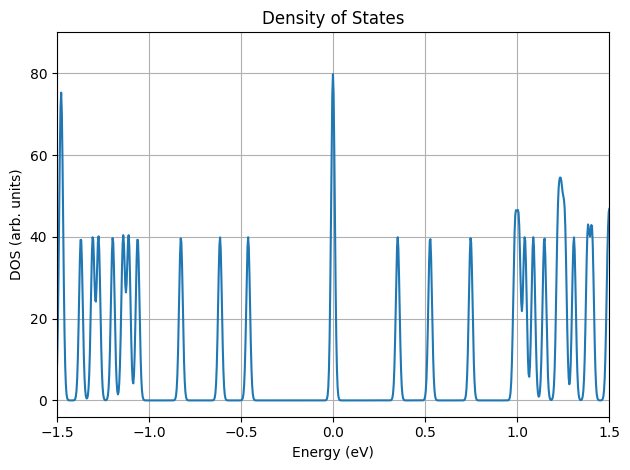

In [38]:
fermi, energies, occupancies = parse_bridge('bridge.txt', n=20)
print("Fermi level:", fermi)
print("Energies:", energies)
print("Occupancies", occupancies)
energies -= fermi
energy_grid, dos = compute_dos(energies, occupancies, smearing=0.01)

plt.plot(energy_grid, dos)
plt.xlabel("Energy (eV)")
plt.ylabel("DOS (arb. units)")
plt.title("Density of States")
plt.grid(True)
plt.xlim(-1.5,1.5)
plt.ylim(top=90)
plt.tight_layout()
plt.show()


### Using GPAW's internal mechanism to compute DOS

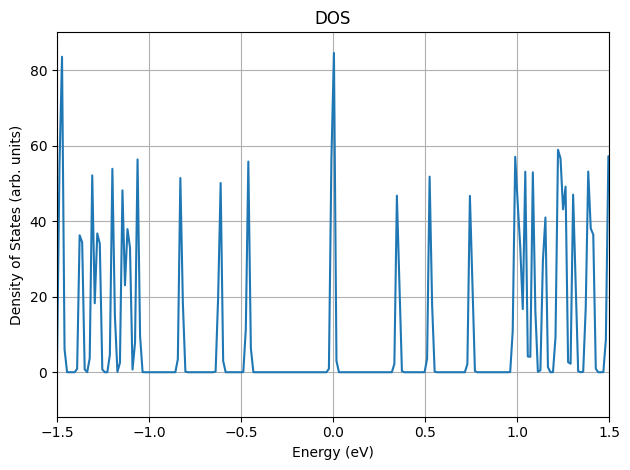

In [39]:
data = np.loadtxt("dos.dat", comments="#")
energies = data[:, 0]
dos = data[:, 1]

plt.plot(energies, dos)
plt.xlabel("Energy (eV)")
plt.ylabel("Density of States (arb. units)")
plt.title("DOS")
plt.grid(True)
plt.xlim(-1.5,1.5)
plt.ylim(top=90)
plt.tight_layout()
plt.show()